<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Series-Plot" data-toc-modified-id="Series-Plot-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Series Plot</a></span></li><li><span><a href="#FFT" data-toc-modified-id="FFT-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FFT</a></span></li><li><span><a href="#Rolling-mean" data-toc-modified-id="Rolling-mean-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Rolling mean</a></span></li><li><span><a href="#statsmodel-seasonal-decomposition" data-toc-modified-id="statsmodel-seasonal-decomposition-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>statsmodel seasonal decomposition</a></span></li><li><span><a href="#Long-term-trend" data-toc-modified-id="Long-term-trend-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Long term trend</a></span></li><li><span><a href="#Spline-Trend" data-toc-modified-id="Spline-Trend-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Spline Trend</a></span></li><li><span><a href="#Linear-trend" data-toc-modified-id="Linear-trend-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Linear trend</a></span></li><li><span><a href="#Seasonality-and-trend-prediction-functions" data-toc-modified-id="Seasonality-and-trend-prediction-functions-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Seasonality and trend prediction functions</a></span></li><li><span><a href="#Décomposition" data-toc-modified-id="Décomposition-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Décomposition</a></span><ul class="toc-item"><li><span><a href="#ADF-sur-le-residuel" data-toc-modified-id="ADF-sur-le-residuel-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>ADF sur le residuel</a></span></li></ul></li><li><span><a href="#ARIMA" data-toc-modified-id="ARIMA-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>ARIMA</a></span></li><li><span><a href="#Optimisation-et-evaluation" data-toc-modified-id="Optimisation-et-evaluation-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Optimisation et evaluation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import dateutil
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
from scipy.fftpack import fftfreq
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
register_matplotlib_converters()

Source du dataset:

https://data.world/data-society/global-climate-change-data/workspace/file?filename=GlobalLandTemperatures%2FGlobalTemperatures.csv

In [2]:
!ls *.csv

GlobalLandTemperatures_GlobalTemperatures.csv


In [3]:
temp = pd.read_csv("GlobalLandTemperatures_GlobalTemperatures.csv")

#temp["dt"] = temp["dt"].apply(dateutil.parser.parse)
temp["dt"] = temp["dt"].apply(lambda x: np.datetime64(x))

temp = temp[['dt','LandAverageTemperature']]
#temp.index = temp.apply( lambda x: x["dt"].year + (x["dt"].month-1)/12, axis=1)
temp = temp.iloc[-500:]
temp.head(12)

,dt,LandAverageTemperature
2692,1974-05-01,11.198
2693,1974-06-01,13.382
2694,1974-07-01,14.288
2695,1974-08-01,14.016
2696,1974-09-01,11.744
2697,1974-10-01,9.098
2698,1974-11-01,5.915
2699,1974-12-01,3.550
2700,1975-01-01,3.059
2701,1975-02-01,3.395


In [4]:
temp.shape

(500, 2)

In [5]:
temp.isna().sum()

dt                        0
LandAverageTemperature    0
dtype: int64

NA Forward fill

In [6]:
temp = temp.fillna(method="ffill")

## Series Plot

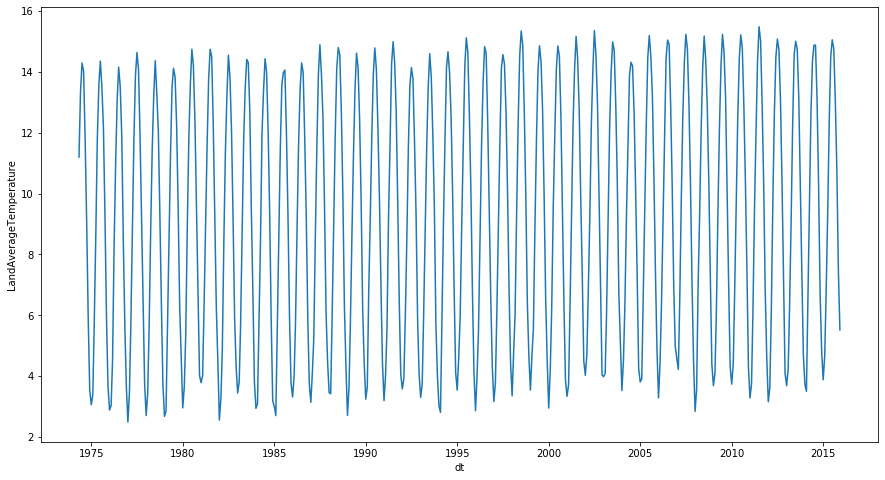

In [7]:
plt.figure(figsize=(15,8))
sns.lineplot(x="dt",y="LandAverageTemperature", data=temp.iloc[-1000:]);

- Saisonalité annuelle
- Tendence de réchauffement

## FFT

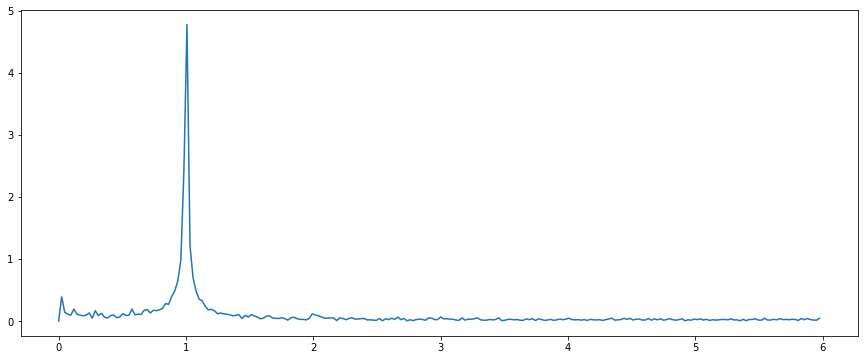

In [8]:
temp_mean = temp["LandAverageTemperature"].mean()
fft_size = temp.shape[0]

#fft = scipy.fft(temp["LandAverageTemperature"])
fft = scipy.fft(temp["LandAverageTemperature"]-temp_mean)

temp_fft = np.abs(fft)
freqs = fftfreq(fft_size,d=1/12)

plt.figure(figsize=(15,6))
#sns.lineplot(x=freqs, y=temp_fft);
#sns.lineplot(x=freqs[0:fft_size//2], y=temp_fft[0:fft_size//2]);
sns.lineplot(x=freqs[0:fft_size//2], y=temp_fft[0:fft_size//2]* 2/fft_size);

A = max(temp_fft)* 2/fft_size
phase = np.angle(fft[np.argmax(temp_fft)])

C'est effectivement un beau sinus. 

## Rolling mean

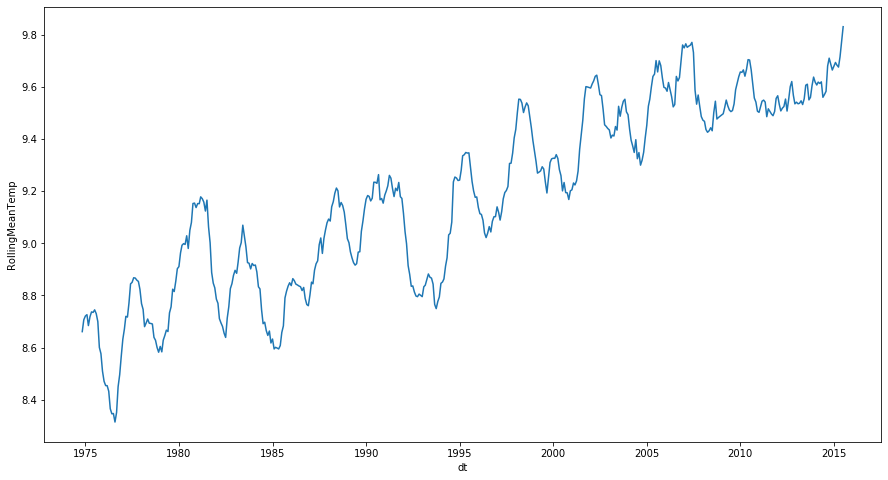

In [9]:
temp["RollingMeanTemp"] = temp["LandAverageTemperature"].rolling(12, center=True).mean()

plt.figure(figsize=(15,8))
sns.lineplot(x="dt" ,y="RollingMeanTemp", data=temp.iloc[-1500:]);

La tendence à la hausse est plus apparente aprés suppression de la saisonalité.

## statsmodel seasonal decomposition

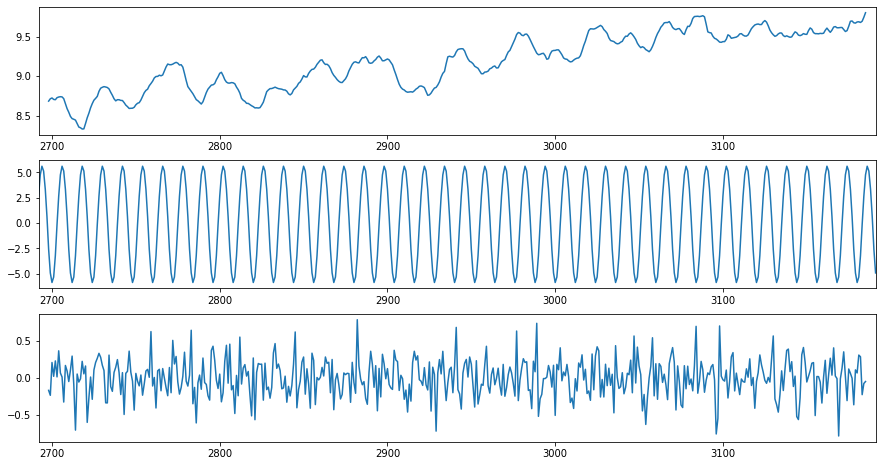

In [10]:
decomp_result = seasonal_decompose(temp[["LandAverageTemperature"]], model='additive', period=12)
plt.figure(figsize=(15,8))
plt.subplot(3,1,1)
decomp_result.trend.plot()
plt.subplot(3,1,2)
decomp_result.seasonal.plot()
plt.subplot(3,1,3)
decomp_result.resid.plot()
plt.show()

In [11]:
ADF_result = adfuller(temp["LandAverageTemperature"])
print('ADF Statistic: %f' % ADF_result[0])
print('p-value: %f' % ADF_result[1])

ADF Statistic: -2.112655
p-value: 0.239456


In [12]:
ADF_result = adfuller(decomp_result.trend.iloc[6:-6])
print('ADF Statistic: %f' % ADF_result[0])
print('p-value: %f' % ADF_result[1])

ADF Statistic: -1.683811
p-value: 0.439472


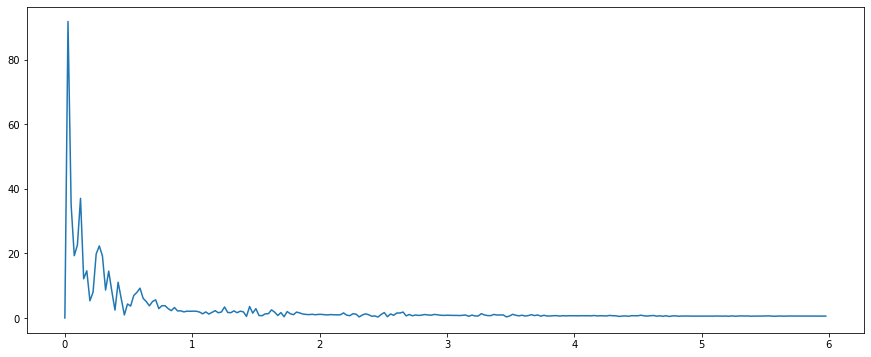

In [13]:
temp_mean = decomp_result.trend.iloc[6:-6].mean()
fft_size = decomp_result.trend.iloc[6:-6].shape[0]

temp_fft = np.abs(scipy.fft(decomp_result.trend.iloc[6:-6]-temp_mean))
freqs = fftfreq(fft_size,d=1/12)

plt.figure(figsize=(15,6))
sns.lineplot(x=freqs[0:fft_size//2], y=temp_fft[0:fft_size//2]);

## Long term trend

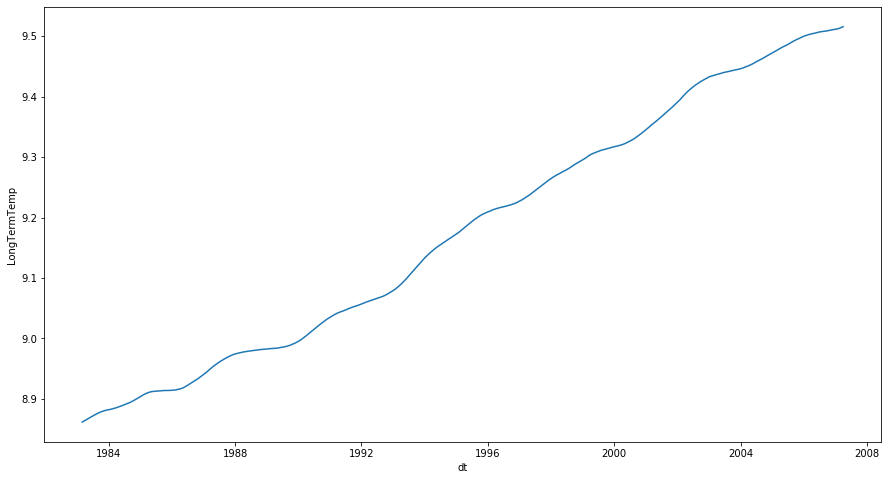

In [14]:
temp["LongTermTemp"] = temp["RollingMeanTemp"].rolling(200, center=True).mean()
plt.figure(figsize=(15,8))
sns.lineplot(x="dt" ,y="LongTermTemp", data=temp.iloc[-1500:]);
#temp_rolling_mean = temp_rolling_mean[100:-99]

## Spline Trend

In [15]:
from scipy import interpolate

In [16]:
X = temp.index.values[6:-5]
y = temp['RollingMeanTemp'].iloc[6:-5]

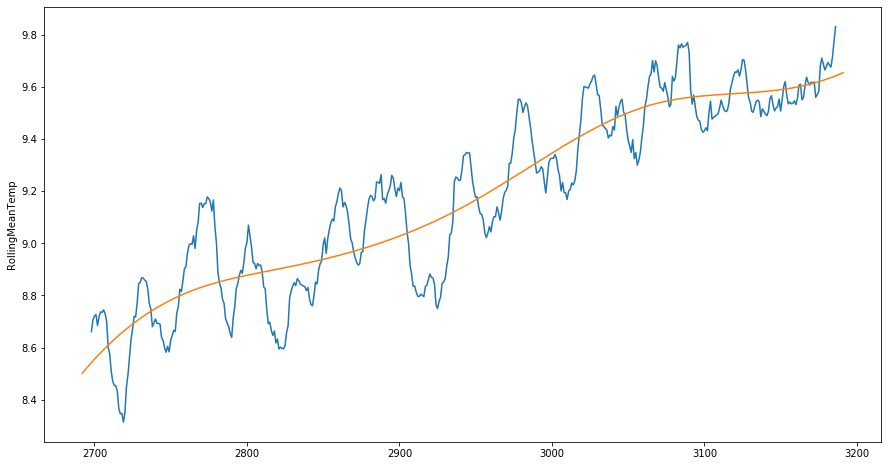

In [17]:
spline = interpolate.UnivariateSpline(X, y, s=10.5, k=3)
spline_trend = pd.Series(index=temp.index, data=spline(temp.index.values)) 
plt.figure(figsize=(15,8))

sns.lineplot(x=temp.index ,y="RollingMeanTemp", data=temp);
sns.lineplot(data=spline_trend);

## Linear trend

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
linear_model = LinearRegression()

X=temp.index.values.reshape(-1,1)[6:-5]
y=temp["RollingMeanTemp"].iloc[6:-5]
linear_model.fit(X, y);

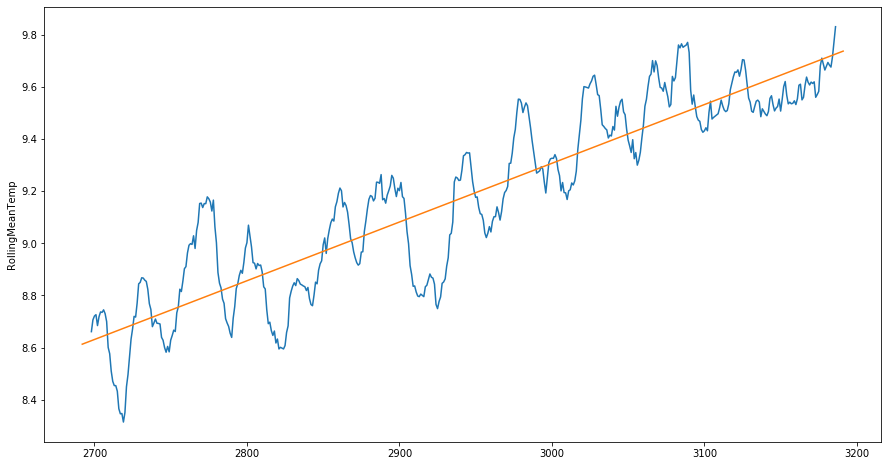

In [20]:
plt.figure(figsize=(15,8))
linear_trend = pd.Series(index=temp.index, data=linear_model.predict(temp.index.values.reshape(-1,1))) 
#sns.lineplot(x=X.reshape(-1) ,y=y);
sns.lineplot(x=temp.index ,y="RollingMeanTemp", data=temp);
sns.lineplot(data=linear_trend);

## Seasonality and trend prediction functions

In [21]:
seasonality_table = decomp_result.seasonal[0:12]
seasonality_table.index = np.mod(seasonality_table.index,12)
def seasonal_predict(n):
    result = pd.Series(index=n, data=seasonality_table[np.mod(n,12)].values)
    return result

In [22]:
def trend_predict(n):
    return pd.Series(index=n, data=linear_model.predict(n.values.reshape(-1,1)))

## Décomposition

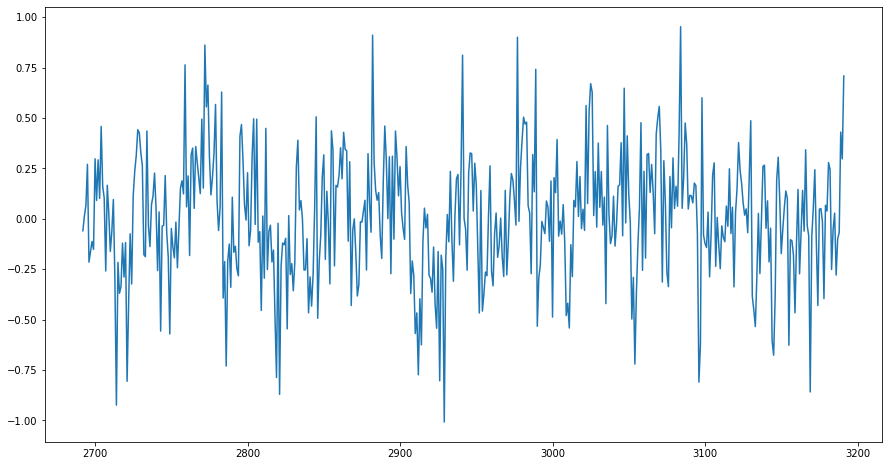

In [23]:
#seasonal = A * np.cos(2*np.pi/12 * np.arange(temp.shape[0])+phase)
seasonal = decomp_result.seasonal#.fillna(method="ffill").fillna(method="bfill")
trend = pd.Series(index=temp.index, data=spline(temp.index))

residual = temp["LandAverageTemperature"] - seasonal - linear_trend
#residual = residual[]

plt.figure(figsize=(15,8))
sns.lineplot(x=temp.index[-500:] ,y=residual.iloc[-500:]);

### ADF sur le residuel

In [24]:
ADF_result = adfuller(residual)
print('ADF Statistic: %f' % ADF_result[0])
print('p-value: %f' % ADF_result[1])

ADF Statistic: -7.523730
p-value: 0.000000


## ARIMA

ARIMA

In [25]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

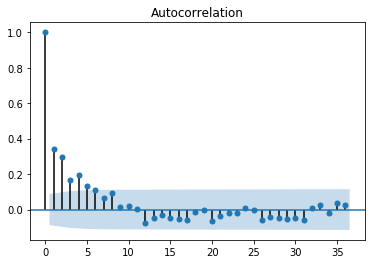

In [26]:
plot_acf(residual, lags=3*12);

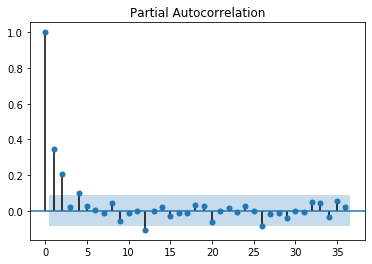

In [27]:
plot_pacf(residual, lags=3*12);

In [39]:
X = temp["LandAverageTemperature"]
X_train = temp["LandAverageTemperature"].iloc[:-100]
X_test = temp["LandAverageTemperature"].iloc[-100:]
#X_train_diff = X_train.diff(periods=12)

#X_train_residual = X_train.rolling(12, center=True).mean().iloc[6:-5]
X_train_residual = (X_train.rolling(12, center=True).mean() - linear_trend.iloc[-600:-100]).iloc[6:-5]
X_fulltrain = (X.rolling(12, center=True).mean() - linear_trend.iloc[-600:]).iloc[6:-5]
#X_train_residual = (X_train.rolling(12, center=True).mean() - spline_trend.iloc[-600:-100]).iloc[6:-5]
#result = seasonal_decompose(X_train, model='additive', period=12)
#X_train_residual = result.resid.iloc[6:-6]

In [93]:
arima = ARIMA(X_train_residual, order = (2,0,6)) # from acf and pacf
arima = ARIMA(X_train_residual, order = (2,0,3)) # from gridsearch
arima = arima.fit()

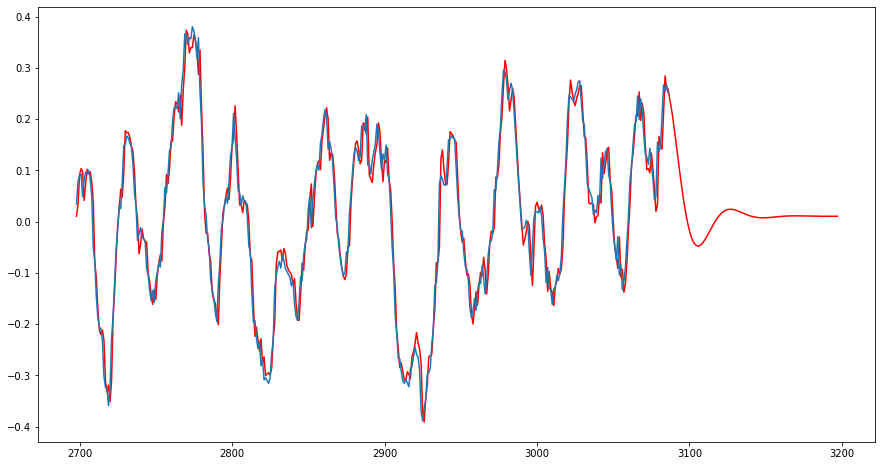

In [94]:
#forecast = arima.forecast(steps=100)[0]
forecast = arima.predict(start=0, end=499)
plt.figure(figsize=(15,8))
sns.lineplot(data=forecast, color="red")
sns.lineplot(data=X_train_residual)
plt.show()

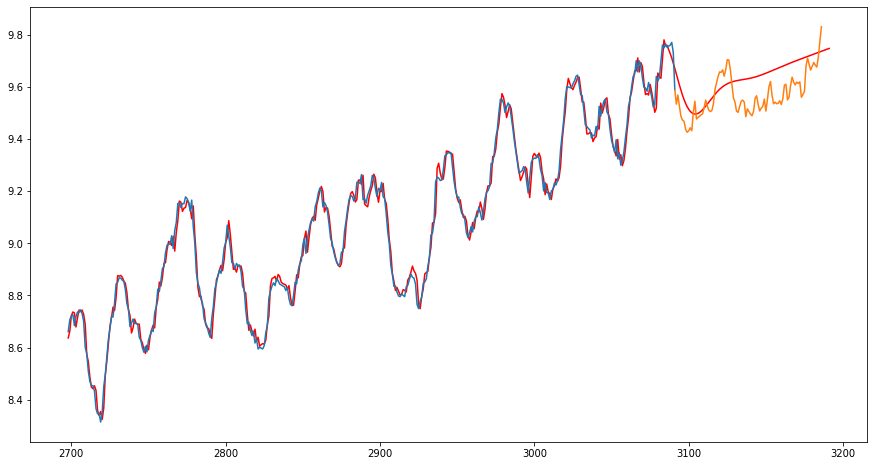

In [95]:
forecast = pd.Series(index=temp.index[-500:], data=arima.predict(start=0, end=499))

plt.figure(figsize=(15,8))
sns.lineplot(data=forecast+linear_trend, color="red")
sns.lineplot(data=temp['RollingMeanTemp'].iloc[-500:-100])
sns.lineplot(data=temp['RollingMeanTemp'].iloc[-101:])
plt.show()

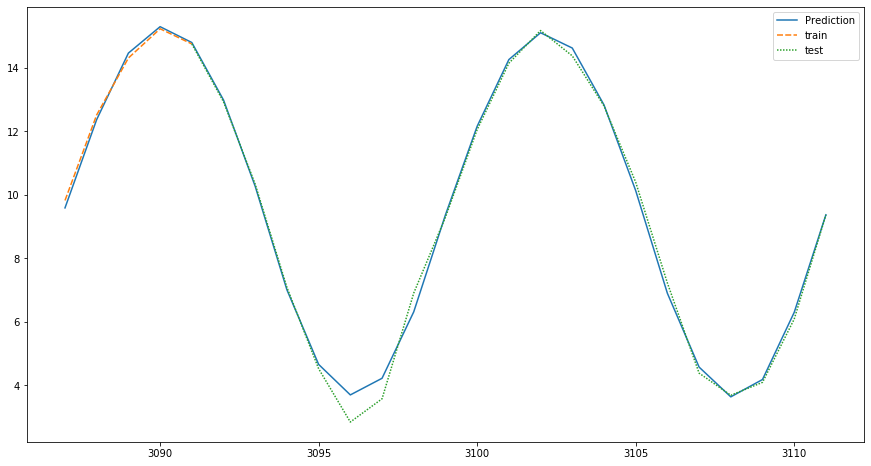

In [96]:
df = pd.DataFrame()
forecast = pd.Series(index=temp.index[-500:], data=arima.predict(start=0, end=499))

periodic = seasonal_predict(temp.index[-500:])
linear_trend = trend_predict(temp.index[-500:])

df["Prediction"] = forecast+linear_trend+periodic
df["train"] = temp['LandAverageTemperature'].iloc[-500:-100]
df["test"] = temp['LandAverageTemperature'].iloc[-101:]
plt.figure(figsize=(15,8))
sns.lineplot(data=df.iloc[-105:-80])
plt.show()

## Optimisation et evaluation

In [92]:
def mse(pred, true):
    return np.mean(np.square(true-pred))

#X_fulltrain
        
step_size=100 #training size step increment
test_size=20 #forecast length
result = {}
for p in range(2,5):
    for q in range(2,6):

        scores=[]
        for step in range(2*step_size, X_fulltrain.shape[0]-test_size, step_size):
            X_train = X_fulltrain[:step]
            X_test = X_fulltrain[step:step+test_size]
            
            arima = ARIMA(X_train, order = (p,0,q))
            arima = arima.fit()
        
            pred = arima.predict(start=step, end=step+test_size)
            scores.append(mse(pred, X_test))
        result[(p,q)] = np.array(scores).mean()

display(result)
print(min(result, key=result.get))

/home/guillaume/.virtualenvs/MachineLearning/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


{(2, 2): 0.015795962206882654,
 (2, 3): 0.014850501762790009,
 (2, 4): 0.014961596702026882,
 (2, 5): 0.01735889541200898,
 (3, 2): 0.015693285195593508,
 (3, 3): 0.014998593495999385,
 (3, 4): 0.01576897035032582,
 (3, 5): 0.015057629147818517,
 (4, 2): 0.015142511109523388,
 (4, 3): 0.014953702100803089,
 (4, 4): 0.015022311032540902,
 (4, 5): 0.020396913520731533}

(2, 3)


In [90]:
min(result, key=result.get)

(2, 4)